In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob
import imageio

In [4]:
import lanelines
import roadplane

from compgraph import CompGraph, CompGraphRunner
import nxpd
nxpd.nxpdParams['show'] = 'ipynb'

In [5]:
from newlanespipeline import computational_graph as cg
from newlanespipeline import parameters as cg_params
from roadplane import prepare_perspective_transforms_custom

In [6]:
cm = np.load('serialize/camera_matrix.npy')
dc = np.load('serialize/dist_coefs.npy')

In [7]:
PIXELS_PER_METER = 420 / 3.7 # approximately

In [8]:
CANVAS_SZ = (500, 1500)
M, Minv = prepare_perspective_transforms_custom(CANVAS_SZ)

In [9]:
test_images = [lanelines.open_image(f) for f in glob('test_images/*.jpg')]
test_images_undist = [cv2.undistort(im, cm, dc) for im in test_images]

In [10]:
warped_images = [cv2.warpPerspective(im, M, CANVAS_SZ, flags=cv2.INTER_LINEAR) for im in test_images_undist]

In [153]:
runner = CompGraphRunner(cg, frozen_tokens=cg_params)
#nxpd.draw(runner.token_manager.to_networkx())

In [12]:
def curvature_poly2(params, at_point):
    
    a, b, _ = params
    return ((1 + (2 * a * at_point + b) ** 2) ** 1.5) / np.abs(2 * a)


def lane_center(poly_x_left, poly_x_right, last_n=15):
    return poly_x_left[-last_n:] + (poly_x_right[-last_n:] - poly_x_left[-last_n:])

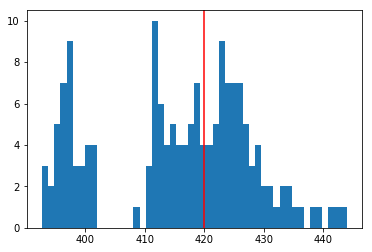

In [13]:
diffs_list = []

for im in test_images_undist:
    
    runner.run(image=im, M=M, Minv=Minv)
    diffs = lane_center(runner['poly_x_left'], runner['poly_x_right'], last_n=20)
    diffs_list.append(diffs)
    
all_diffs = np.concatenate(diffs_list)

_ = plt.hist(all_diffs, bins=50)
plt.axvline(420, color='r')

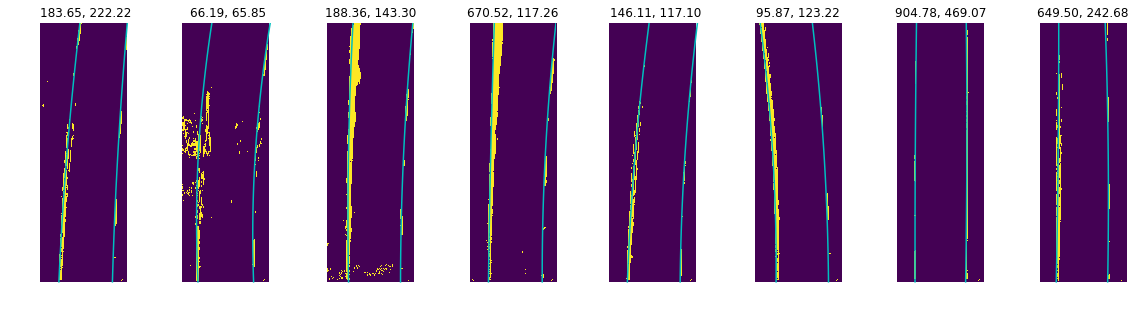

In [14]:
last_y = CANVAS_SZ[1]

plt.figure(figsize=(20, 5))

for i, im in enumerate(test_images_undist):
    runner.run(image=im, M=M, Minv=Minv)
    
    plt.subplot(1, 8, i+1)
    plt.imshow( runner['all_thresholds'])
    _ = plt.axis('off')
    
    plt.plot(runner['poly_x_left'], runner['poly_y'], color='c')
    plt.plot(runner['poly_x_right'], runner['poly_y'], color='c')
    
    curv_left = curvature_poly2(runner['p_coefs_left'], last_y)
    curv_right = curvature_poly2(runner['p_coefs_right'], last_y)
    
    plt.title('{:.2f}, {:.2f}'.format(curv_left / PIXELS_PER_METER, curv_right / PIXELS_PER_METER))

In [15]:
video_rd = imageio.get_reader('project_video.mp4')

In [16]:
all_p_coefs_left = []
all_p_coefs_right = []

for frame in video_rd:
    
    runner.run(image=frame, M=M, Minv=Minv)
    
    all_p_coefs_left.append(runner['p_coefs_left'])
    all_p_coefs_right.append(runner['p_coefs_right'])
    
all_p_coefs_left = np.array(all_p_coefs_left)
all_p_coefs_right = np.array(all_p_coefs_right)

In [120]:
def compute_diffs(arr):
    
    assert len(arr.shape) == 2
    
    n_records, n_dims = arr.shape
    new_shape = (n_records-1, n_dims)
    
    diffs = np.zeros(new_shape)
    
    for i in range(1, n_records):
        diffs[i - 1, :] = arr[i, :] - arr[i - 1, :]
        
    return diffs


In [125]:
all_diffs_left = compute_diffs(all_p_coefs_left)
all_diffs_right = compute_diffs(all_p_coefs_right)

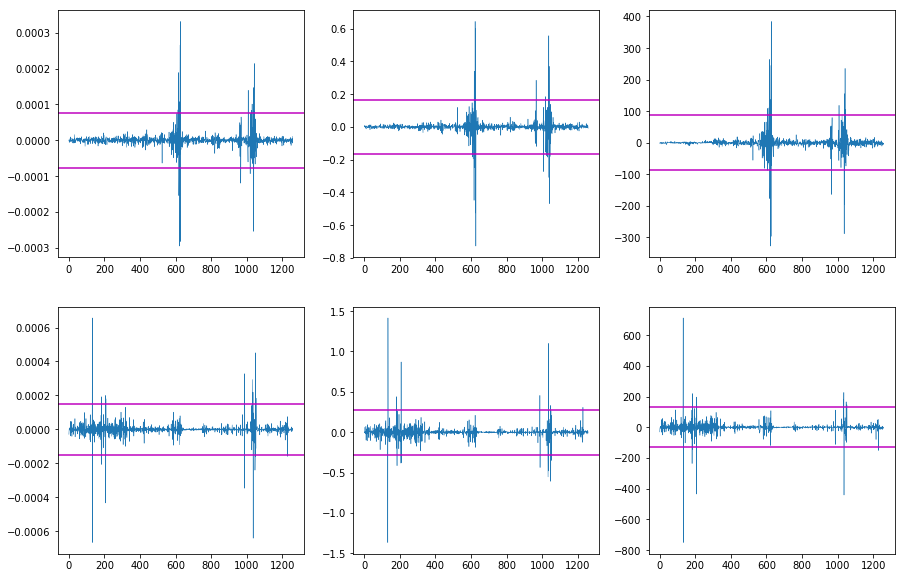

In [131]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.plot(all_diffs_left[:, 0], linewidth=0.5)
plt.axhline(all_diffs_left[:, 0].std() * 3, color='m')
plt.axhline(-all_diffs_left[:, 0].std() * 3, color='m')

plt.subplot(2, 3, 2)
plt.plot(all_diffs_left[:, 1], linewidth=0.5)
plt.axhline(all_diffs_left[:, 1].std() * 3, color='m')
plt.axhline(-all_diffs_left[:, 1].std() * 3, color='m')

plt.subplot(2, 3, 3)
plt.plot(all_diffs_left[:, 2], linewidth=0.5)
plt.axhline(all_diffs_left[:, 2].std() * 3, color='m')
plt.axhline(-all_diffs_left[:, 2].std() * 3, color='m')

plt.subplot(2, 3, 4)
plt.plot(all_diffs_right[:, 0], linewidth=0.5)
plt.axhline(all_diffs_right[:, 0].std() * 3, color='m')
plt.axhline(-all_diffs_right[:, 0].std() * 3, color='m')

plt.subplot(2, 3, 5)
plt.plot(all_diffs_right[:, 1], linewidth=0.5)
plt.axhline(all_diffs_right[:, 1].std() * 3, color='m')
plt.axhline(-all_diffs_right[:, 1].std() * 3, color='m')

plt.subplot(2, 3, 6)
plt.plot(all_diffs_right[:, 2], linewidth=0.5)
plt.axhline(all_diffs_right[:, 2].std() * 3, color='m')
plt.axhline(-all_diffs_right[:, 2].std() * 3, color='m')



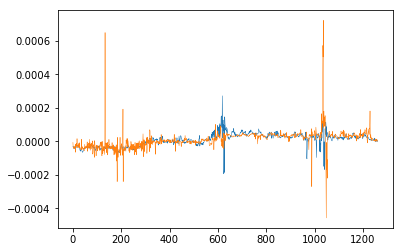

In [132]:
plt.plot(all_p_coefs_left[:, 0], linewidth=0.5)
plt.plot(all_p_coefs_right[:, 0], linewidth=0.5)

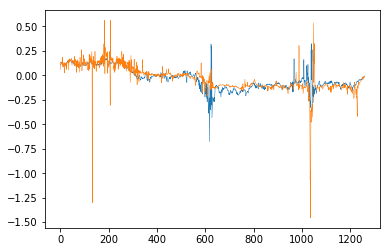

In [103]:
plt.plot(all_p_coefs_left[:, 1], linewidth=0.5)
plt.plot(all_p_coefs_right[:, 1], linewidth=0.5)

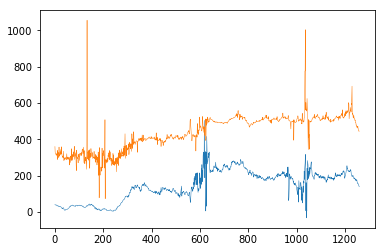

In [133]:
plt.plot(all_p_coefs_left[:, 2], linewidth=0.5)
plt.plot(all_p_coefs_right[:, 2], linewidth=0.5)

In [56]:
class Memory(object):
    
    def __init__(self, size=5):
        self._data = []
        self._n = 0
        self._size = size
        
    def insert(self, val):
        
        self._data.append(val)
        self._n += 1
        
        if self._n > self._size:
            self._data = self._data[1:]
            
    def last(self):
        return self._data[-1]
        
    def mean(self):
        return np.mean(self._data, axis=0)
    
    def std(self):
        return np.std(self._data, axis=0)
    
    def is_empty(self):
        return self._data == []
    
    def is_full(self):
        return len(self._data) == self._size
        

In [58]:
mem = Memory(size=3)
print(mem.is_empty())

for i in range(15):
    mem.insert(i)
    print( len(mem._data), mem._data, 3 * mem.std(), mem.is_full() )
    
    

True
1 [0] 0.0 False
2 [0, 1] 1.5 False
3 [0, 1, 2] 2.44948974278 True
3 [1, 2, 3] 2.44948974278 True
3 [2, 3, 4] 2.44948974278 True
3 [3, 4, 5] 2.44948974278 True
3 [4, 5, 6] 2.44948974278 True
3 [5, 6, 7] 2.44948974278 True
3 [6, 7, 8] 2.44948974278 True
3 [7, 8, 9] 2.44948974278 True
3 [8, 9, 10] 2.44948974278 True
3 [9, 10, 11] 2.44948974278 True
3 [10, 11, 12] 2.44948974278 True
3 [11, 12, 13] 2.44948974278 True
3 [12, 13, 14] 2.44948974278 True


In [144]:
class Smoother(object):
    
    def __init__(self, runner, M, Minv, token_names, diff_thresholds):
        self._runner = runner
        self._token_names = token_names
        self._M = M
        self._Minv = Minv
        
        self._last = {tk: None for tk in token_names}
        
        self._dt = diff_thresholds
    
    def __call__(self, im):
        
        res = {}
        
        self._runner.run(image=im, M=self._M, Minv=self._Minv)
        
        for tk in self._token_names:            
            
            val = runner[tk]

            if self._last[tk] is None: # the first point
                self._last[tk] = val
                res[tk] = val
                continue
                
            diff = val - self._last[tk]
            
            if np.any( np.abs(diff) > self._dt[tk] ):
                new_val = self._last[tk]
            else:
                new_val = 0.5 * (val + self._last[tk])
            
            self._last[tk] = new_val
            res[tk] = new_val
            
        return res

In [137]:
dt = {
    'p_coefs_left': np.array([1e-4, 0.15, 90.]),
    'p_coefs_right': np.array([1.8e-4, 0.25, 150.])
}

In [149]:
#N = 100
N = len(video_rd)

smoo = Smoother(runner, M, Minv, ['p_coefs_left', 'p_coefs_right'], diff_thresholds=dt)

sm_p_coefs_left = []
sm_p_coefs_right = []

for i, frame in enumerate(video_rd):
    
    if i > N:
        break
    
    res = smoo(frame)
    
    runner.run(image=frame, M=M, Minv=Minv)
    
    sm_p_coefs_left.append(res['p_coefs_left'])
    sm_p_coefs_right.append(res['p_coefs_right'])
    
sm_p_coefs_left = np.array(sm_p_coefs_left)
sm_p_coefs_right = np.array(sm_p_coefs_right)

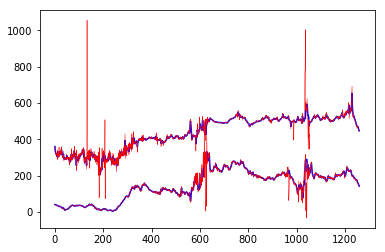

In [150]:
plt.plot(sm_p_coefs_left[:, 2], color='b')
plt.plot(sm_p_coefs_right[:, 2], color='b')

plt.plot(all_p_coefs_left[:N, 2], linewidth=0.5, color='r')
plt.plot(all_p_coefs_right[:N, 2], linewidth=0.5, color='r')

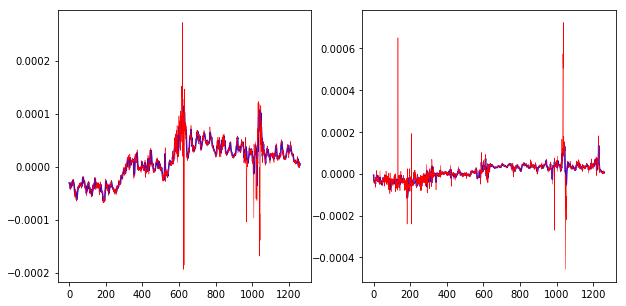

In [151]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(sm_p_coefs_left[:, 0], color='b')
plt.plot(all_p_coefs_left[:N, 0], linewidth=0.5, color='r')

plt.subplot(1, 2, 2)
plt.plot(sm_p_coefs_right[:, 0], color='b')
plt.plot(all_p_coefs_right[:N, 0], linewidth=0.5, color='r')

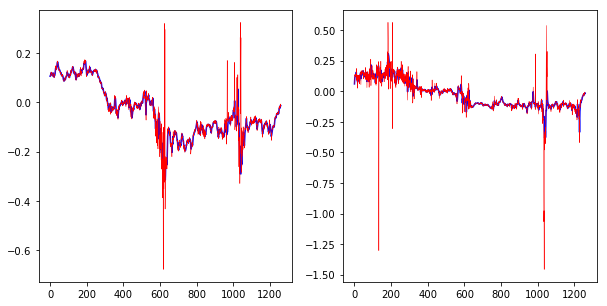

In [152]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(sm_p_coefs_left[:, 1], color='b')
plt.plot(all_p_coefs_left[:N, 1], linewidth=0.5, color='r')

plt.subplot(1, 2, 2)
plt.plot(sm_p_coefs_right[:, 1], color='b')
plt.plot(all_p_coefs_right[:N, 1], linewidth=0.5, color='r')

In [42]:
class OldSmoother(object):
    
    def __init__(self, runner, M, Minv, token_names):
        self._runner = runner
        self._token_names = token_names
        self._M = M
        self._Minv = Minv
        
        self._last = {tk: None for tk in token_names}
        self._diff = {tk: None for tk in token_names}
    
    def __call__(self, im, diff_ratio_threshold=50.):
        
        res = {}
        
        self._runner.run(image=im, M=self._M, Minv=self._Minv)
        
        for tk in self._token_names:            
            val = runner[tk]

            if self._last[tk] is None: # the first point
                #print('first')
                self._last[tk] = val
                res[tk] = val
                continue
                
            smoothed = 0.5 * (val + self._last[tk])
            diff = smoothed - self._last[tk]
            
            
            if self._diff[tk] is not None: # 3rd point and onwards

                diff_ratio = diff / self._diff[tk]
                
                if np.linalg.norm(diff_ratio) > diff_ratio_threshold:
                    #print('anomaly')
                    extrapolated = self._last[tk] + self._diff[tk]
                    self._last[tk] = extrapolated
                    res[tk] = extrapolated
                    continue     
            
                    
            #print('ok')
            self._diff[tk] = diff
            self._last[tk] = smoothed
            res[tk] = smoothed
            
        return res

In [135]:
class SmootherWithMemory(object):
    
    def __init__(self, runner, M, Minv, token_names, memory_size=5):
        self._runner = runner
        self._token_names = token_names
        self._M = M
        self._Minv = Minv
        
        self._mem = {tk: Memory(memory_size) for tk in token_names}
    
    def __call__(self, im):
        
        res = {}
        
        self._runner.run(image=im, M=self._M, Minv=self._Minv)
        
        for tk in self._token_names:            
            
            val = runner[tk]

            if not self._mem[tk].is_full(): 
                self._mem[tk].insert(val)
                res[tk] = val
                continue

            diff = np.linalg.norm(val - self._mem[tk].mean())
            threshold = np.linalg.norm(50 * self._mem[tk].std())
            
            if diff > threshold:
                #self._mem[tk].insert( self._mem[tk].last() )
                self._mem[tk].insert( self._mem[tk].mean() )
                res[tk] = self._mem[tk].last()
                continue
                
            #smoothed = 0.5 * (val + self._mem[tk].last())
            smoothed = 0.5 * (val + self._mem[tk].mean())
            res[tk] = smoothed
            
        return res
